<a href="https://colab.research.google.com/github/noambassat/Colorectal_Histology_Classifier/blob/main/8_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [96]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
file_path = "/content/drive/MyDrive/"
data_name  = "full_rap_df_cleaned_3_classifiers.xlsx"

In [98]:
data = pd.read_excel(file_path + data_name)

Exception ignored in: <function ZipFile.__del__ at 0x7d941aae14e0>
Traceback (most recent call last):
  File "/usr/lib/python3.11/zipfile.py", line 1895, in __del__
    self.close()
  File "/usr/lib/python3.11/zipfile.py", line 1912, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


# Classifier's Statistics

In [99]:
def plot_statistics(data, col, quest):
    # ספירת המקרים השונים בעמודה
    value_counts = data[col].value_counts()
    print(value_counts)
    # יצירת הגרף
    fig, ax = plt.subplots(figsize=(8, 8))
    wedges, texts, autotexts = ax.pie(
    value_counts,
    labels=quest,
    autopct='%1.1f%%',
    textprops=dict(color="black"),
    startangle=90
)

# התאמת גודל הטקסטים
    plt.setp(autotexts, size=10, weight="bold")
    plt.setp(texts, size=12)
    plt.title(f'Distribution of {col}')

    plt.show()

    # הדפסת הנתונים מתחת לגרף
    print(f"Data distribution for '{col}':")

    total = sum(map(lambda count: count, value_counts))

    print(f"Total of {total} cases where checked.")

Others_classifier_treshold_prediction
0    5983
1    1115
Name: count, dtype: int64


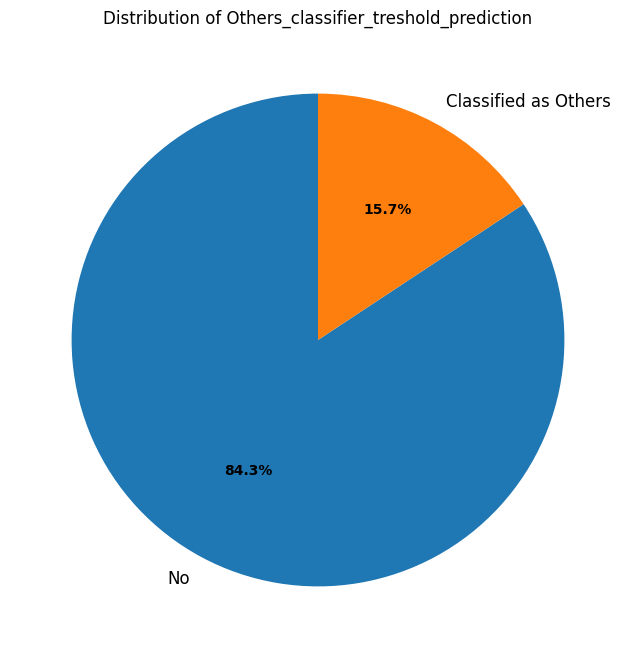

Data distribution for 'Others_classifier_treshold_prediction':
Total of 7098 cases where checked.


In [100]:
plot_statistics(data,'Others_classifier_treshold_prediction',['No','Classified as Others'])

first_classifier_treshold_prediction
0.0    5690
1.0     293
Name: count, dtype: int64


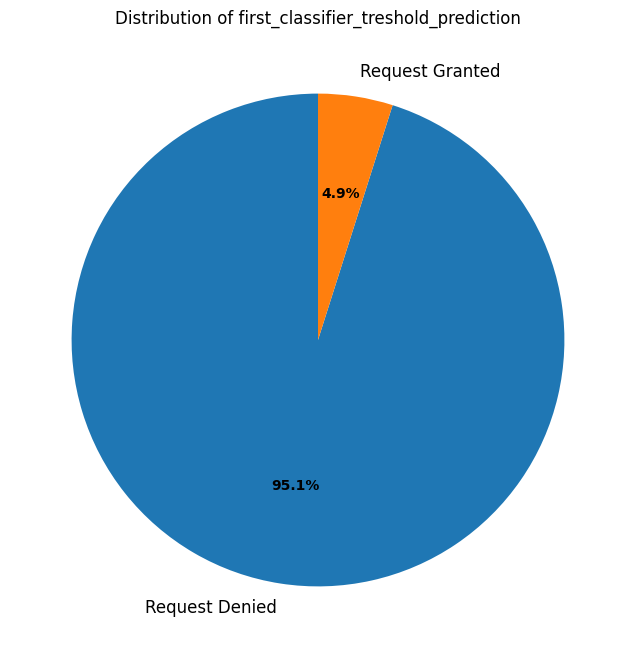

Data distribution for 'first_classifier_treshold_prediction':
Total of 5983 cases where checked.


In [101]:
plot_statistics(data,'first_classifier_treshold_prediction',['Request Denied','Request Granted'])

second_classifier_treshold_prediction
1.0    156
0.0    137
Name: count, dtype: int64


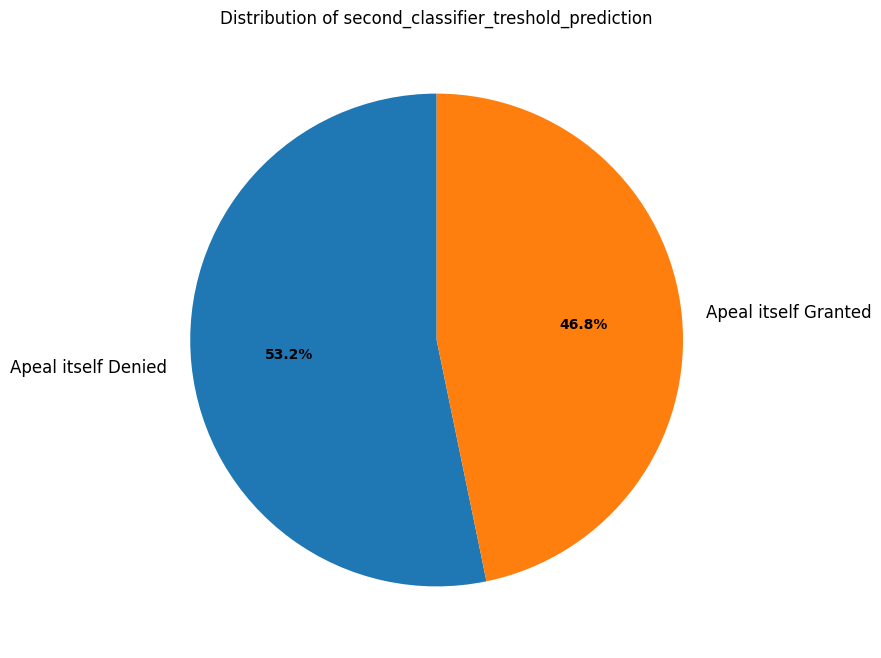

Data distribution for 'second_classifier_treshold_prediction':
Total of 293 cases where checked.


In [102]:
plot_statistics(data,'second_classifier_treshold_prediction',['Apeal itself Denied','Apeal itself Granted'])

# Add public and private sides

In [103]:
sides_path = "sides_values with lables.xlsx"
sides_df = pd.read_excel(file_path+sides_path)

In [104]:
sides_df["Public Sides"].unique()[5]

' באמצעות השירות המשפטי של עיריית תל אביב'

In [105]:
sides_df["Private Sides"].unique()[5]

'   ניקולאי טיטוב  ויקטור שניידרמן  אלכסיי וולוביק'

In [106]:
def debug_message(message, value=None):
    if value is not None:
        print(f"{message}: {value}")
    else:
        print(message)

# פונקציה לניקוי ערכים
def safe_str(value):
    """
    Converts a value to a safe string, handling non-string types gracefully.
    """
    try:
        if pd.isna(value) or value == "" or value == []:
            return ""
        if isinstance(value, list):
            return " ".join([str(v) for v in value if isinstance(v, str)]).strip()
        return str(value).strip()
    except Exception as e:
        debug_message("Error converting value to string", value)
        return ""

# פונקציה לניקוי טקסט
def clean_text(text):
    """
    Cleans the text by removing unwanted characters and fixing formatting issues.
    """
    # Remove leading and trailing whitespace
    text = text.strip()

    # Fix \n or n between Hebrew words
    text = re.sub(r'(?<=[\u0590-\u05FF])\s*[n\\n]+\s*(?=[\u0590-\u05FF])', ' ', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    return text

def publc_side(value, sides_df):
    """
    Determines if the value belongs to a public entity based on predefined lists and patterns.
    """
    try:
        value = safe_str(value)
        value_cleaned = clean_text(value)

        # בדיקת מילים קבועות בתור "ציבורי"
        keywords = sides_df["Public Sides"].dropna().unique().tolist()
        public_terms = [
        "רשות מקרקעי ישראל", "מדינת ", "מועצה ", "שירות ה", "היחידה הארצי", "מדינתישראל", "לאכיפת ", "הרשות ל", "חוף ",
        "המשרד ל", 'יועמ"ש', "המשפטי לממשלה", "מנהל מקרקעי", "פרקליטות", "שירות בתי הסוהר", 'שב"ס', 'מע"מ', "מכס ", 'קמ"ט',
        "ועדת תכנון", "מרכז השלטון", "משטרה", "הסנגוריה הציבורית", "מינהל מקרקעי", "עירית ", "רשויות", "איגוד ערים",
        "עיריית ", "מדינת ישראל", "משרד ה", "מקרקעי ישראל", "שר ה", "שרת ה", "מועצת ", 'רנ"ג', "סרן", "מחוז ",
        "מ דינת ישראל", "שרות בתי הסוהר", 'סג"ם', "(במיל)", "(מיל)", "עריית ", "המחלקה לחקירת שוטרים", "יושבי ראש",
        "רשות ה", "אלוף ", 'יו"ר', "יושב ראש", "ראש עיריית", "ועדה", "צבא", "מפקד", "פיקוד", "משטרת", "משטרה"
    ]
        # אם אחד מהמונחים מופיע, צד ציבורי
        if any(term in value_cleaned for term in public_terms + keywords):
            return 1

        # במידה ואין התאמה, נבדוק לפי אורכים ודפוסים כלליים
        if len(value_cleaned) > 5 and " " in value_cleaned:
            return 0

        return None
    except Exception as e:
        return None


# פונקציה לשיוך צד המדינה
def assign_state_side(value, sides_df):
    """
    Maps the side to public ('ב'), private ('א'), or undefined ('לא מוגדר').
    """
    try:
        value = safe_str(value)
        result = publc_side(value, sides_df)

        if result == 1:
            return "ב"
        elif result == 0:
            return "א"
        else:
            return "לא מוגדר"
    except Exception as e:
        debug_message("Error assigning state side for value", value)
        return "לא מוגדר"


In [107]:
check_nulls_b = data[data["צד ב'"].isna()]
check_nulls_b["צד א'"].unique()

array(["[['יואב פרנקל', 'מילי פרנקל']]", "[['שופאני כרם']]",
       "[['אלי חי']]", "[['עופר בראז']]", "[['פלוני']]",
       "[['אבו קרינאת עבדאללה ת.ז. 029856184 ']]", nan,
       "[['צבי שטיין ']]", "[['דניאל בן עזרא עמרם']]", "[['עזרא לקס']]",
       "[['חיים חוטה']]", "[['ארקדי אלזרוב']]", "[['אליעזר משיאשוילי']]",
       "[['יעקב שאיו']]", "[['מוחמד קעדאן']]", "[['נאסר רומל']]",
       "[['יצחק זינגר']]", "[['טלאל מלאחי']]", "[['פריד שלבי']]",
       "[['אליעזר לביא']]", "[['יגאל מדר']]", "[['איברהים חאג יחיא']]",
       "[['בועז פרחי']]", "[['אוריאל דודסון ']]", "[['אליהו מחפוד ']]",
       "[['איתמר נמדר ']]", "[['טוליב רחימוב ']]", "[['מוחמד משהראוי']]",
       "[['אברהם שריקי']]", "[['ציון זלה']]", "[['מאיר טוללה ']]",
       "[['יוסף סוריאס ']]", "[['שי שווגר ']]", "[['רן אברי ']]",
       "[['ליאור אבוקסיס ']]", "[['בועז אברהם ']]", "[['רחמים נחום ']]",
       "[['רפאל ואקין']]", "[['דרור כהן']]", "[['גאלב חרחש']]",
       "[['משה חדש']]", "[['אמיר אורלי']]", "[['אשר יגודייב

In [108]:
# ניקוי כללי של העמודה "צד ב'"
data["צד ב'"] = data["צד ב'"].astype(str).str.strip()  # הסרת רווחים
data["צד ב'"] = data["צד ב'"].replace(r'\s+', ' ', regex=True)  # הסרת רווחים מיותרים
data["צד ב'"] = data["צד ב'"].replace(r'[^\w\s]', '', regex=True)  # הסרת תווים מיוחדים


In [109]:
data["צד המדינה"] = data["צד ב'"].apply(lambda x: assign_state_side(x, sides_df))


In [110]:
unknown_values = data[data["צד המדינה"] == "לא מוגדר"]
unknown_values["צד ב'"].unique()

array(['nan', 'מקרוסופט', 'מחש', 'פלוני', 'פלונית', 'n'], dtype=object)

In [111]:
unknown_values["צד א'"].unique()

array(["[['יואב פרנקל', 'מילי פרנקל']]", "[['חביב יעקב']]",
       "[['שופאני כרם']]", "[['יוסי סבן']]", "[['אלי חי']]",
       "[['פלוני']]", "[['עופר בראז']]", "[['פלונית']]",
       "[['אבו קרינאת עבדאללה ת.ז. 029856184 ']]", nan,
       "[['צבי שטיין ']]", "[['דניאל בן עזרא עמרם']]", "[['עזרא לקס']]",
       "[['חיים חוטה']]", "[['ארקדי אלזרוב']]", "[['אליעזר משיאשוילי']]",
       "[['יעקב שאיו']]", "[['מוחמד קעדאן']]", "[['נאסר רומל']]",
       "[['יצחק זינגר']]", "[['טלאל מלאחי']]", "[['פריד שלבי']]",
       "[['אליעזר לביא']]", "[['יגאל מדר']]",
       "[['מאיר ורדי', 'עיריית נתניה \\n', 'אורן בוארון\\n']]",
       "[['איברהים חאג יחיא']]", "[['בועז פרחי']]",
       "[['אוריאל דודסון ']]", "[['אליהו מחפוד ']]", "[['איתמר נמדר ']]",
       "[['טוליב רחימוב ']]", "[['מוחמד משהראוי']]", "[['אברהם שריקי']]",
       "[['ציון זלה']]", "[['מאיר טוללה ']]", "[['יוסף סוריאס ']]",
       "[['שי שווגר ']]", "[['רן אברי ']]", "[['ליאור אבוקסיס ']]",
       "[['בועז אברהם ']]", "[['רחמים נחו

In [112]:
data["צד המדינה"].value_counts()

,count
צד המדינה,
ב,6934
א,103
לא מוגדר,61


In [113]:
for i, value in zip(data[data["צד המדינה"] == "לא מוגדר"].index,
                    data[data["צד המדינה"] == "לא מוגדר"]["צד א'"]):

    if(assign_state_side(value,sides_df)=="ב"):
      print(value)
      data["צד המדינה"] = 'א'
      print("מתוקן:" ,data["צד המדינה"][i])
    elif(assign_state_side(value,sides_df)=="א"):
      print("הפונציה מחזירה על  זה צד א'")
      print("צד המדינה: ",data["צד המדינה"][i])
      print("א: ",data["צד א'"][i])
      print("ב: ",data["צד ב'"][i])
    # data["צד המדינה"] = 'ב'
    # print(data["צד המדינה"][i])

הפונציה מחזירה על  זה צד א'
צד המדינה:  לא מוגדר
א:  [['יואב פרנקל', 'מילי פרנקל']]
ב:  nan
הפונציה מחזירה על  זה צד א'
צד המדינה:  לא מוגדר
א:  [['חביב יעקב']]
ב:  מקרוסופט
הפונציה מחזירה על  זה צד א'
צד המדינה:  לא מוגדר
א:  [['שופאני כרם']]
ב:  nan
הפונציה מחזירה על  זה צד א'
צד המדינה:  לא מוגדר
א:  [['יוסי סבן']]
ב:  מחש
הפונציה מחזירה על  זה צד א'
צד המדינה:  לא מוגדר
א:  [['אלי חי']]
ב:  nan
הפונציה מחזירה על  זה צד א'
צד המדינה:  לא מוגדר
א:  [['עופר בראז']]
ב:  nan
הפונציה מחזירה על  זה צד א'
צד המדינה:  לא מוגדר
א:  [['אבו קרינאת עבדאללה ת.ז. 029856184 ']]
ב:  nan
הפונציה מחזירה על  זה צד א'
צד המדינה:  לא מוגדר
א:  [['צבי שטיין ']]
ב:  nan
הפונציה מחזירה על  זה צד א'
צד המדינה:  לא מוגדר
א:  [['דניאל בן עזרא עמרם']]
ב:  nan
הפונציה מחזירה על  זה צד א'
צד המדינה:  לא מוגדר
א:  [['עזרא לקס']]
ב:  nan
הפונציה מחזירה על  זה צד א'
צד המדינה:  לא מוגדר
א:  [['חיים חוטה']]
ב:  nan
הפונציה מחזירה על  זה צד א'
צד המדינה:  לא מוגדר
א:  [['ארקדי אלזרוב']]
ב:  nan
הפונציה מחזירה על  זה 

In [114]:

unknown_values = data[data["צד המדינה"] == "לא מוגדר"]
unknown_values["צד ב'"].unique()

array([], dtype=object)

צד המדינה
א    7098
Name: count, dtype: int64


ValueError: 'labels' must be of length 'x', not 3

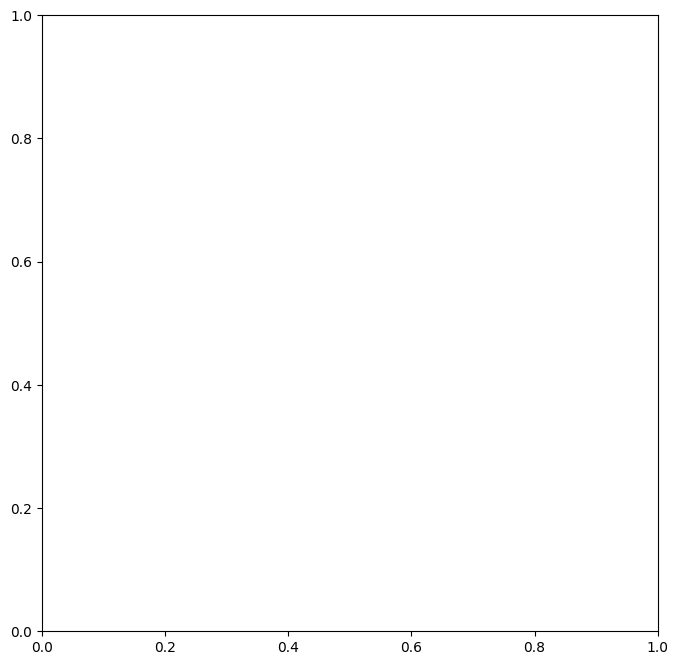

In [115]:
plot_statistics(data,'צד המדינה',['א','ב',"None"])

In [ ]:
data.to_excel(file_path + "full_rap_df_cleaned_3_classifiers_with_state's_side.xlsx", index=False)